In [1]:
!nvidia-smi

Wed Jun 18 06:21:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#!unzip /content/dataset.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
imbalance_data = pd.read_csv("imbalanced_data.csv")

In [5]:
imbalance_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
imbalance_data.columns

Index(['id', 'label', 'tweet'], dtype='object')

## EDA

<Axes: xlabel='label', ylabel='count'>

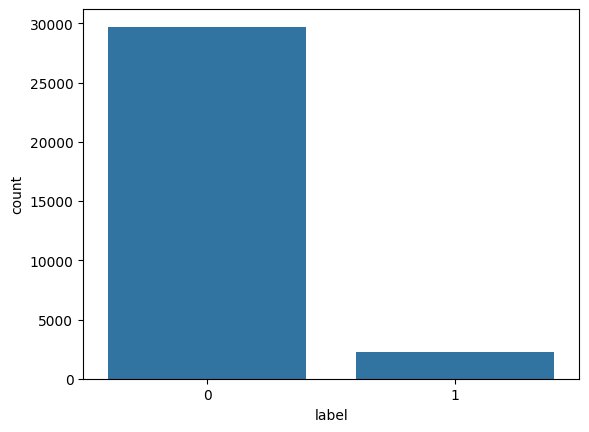

In [7]:
sns.countplot(x = 'label', data = imbalance_data)

In [8]:
imbalance_data["label"].value_counts()

,count
label,
0,29720
1,2242


##
- 0 = No Hate
- 1 = Hate

In [9]:
imbalance_data.shape

(31962, 3)

In [10]:
imbalance_data.isnull().sum()

,0
id,0
label,0
tweet,0


In [11]:
imbalance_data.drop("id", axis= 1, inplace= True)

In [12]:
imbalance_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [13]:
raw_data = pd.read_csv("raw_data.csv")
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [14]:
raw_data.shape

(24783, 7)

In [15]:
raw_data.isnull().sum()

,0
Unnamed: 0,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


In [16]:
raw_data.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [17]:
raw_data.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis = 1, inplace=True)

In [18]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [19]:
raw_data["class"].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [20]:
raw_data["class"].unique()

array([2, 1, 0])

<Axes: xlabel='class', ylabel='count'>

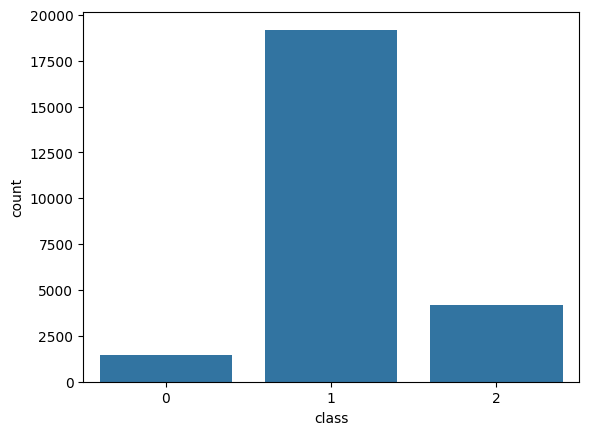

In [21]:
sns.countplot(x = 'class', data = raw_data)

- class 0: hate
- class 1: abusive
- class 2: no hate

In [22]:
# Combine class 1 and 0
raw_data[raw_data["class"]==0]["class"] = 1

<ipython-input-22-3572736624>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[raw_data["class"]==0]["class"] = 1


In [23]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [24]:
raw_data["class"].unique

<bound method Series.unique of 0        2
1        1
2        1
3        1
4        1
        ..
24778    1
24779    2
24780    1
24781    1
24782    2
Name: class, Length: 24783, dtype: int64>

In [25]:
raw_data['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [26]:
raw_data[raw_data["class"]==0]

,class,tweet
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http..."
...,...,...
24576,0,this guy is the biggest faggot omfg
24685,0,which one of these names is more offensive kik...
24751,0,you a pussy ass nigga and I know it nigga.
24776,0,you're all niggers


In [27]:
# Replace the value of 0 to 1
raw_data['class'].replace({0:1},inplace=True)

In [28]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [29]:
raw_data['class'].unique()

array([2, 1])

<Axes: xlabel='class', ylabel='count'>

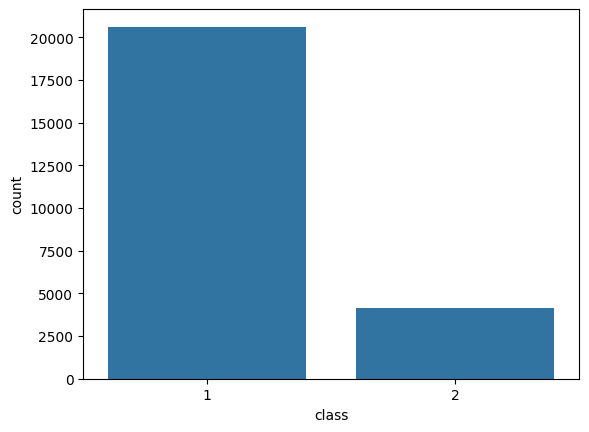

In [30]:
sns.countplot(x = 'class', data = raw_data)

In [31]:
raw_data["class"].value_counts()

,count
class,
1,20620
2,4163


In [32]:
# let's replace the values of 2 to 0
raw_data['class'].replace({2:0},inplace=True)

In [33]:
raw_data.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [34]:
raw_data['class'].unique()

array([0, 1])

<Axes: xlabel='class', ylabel='count'>

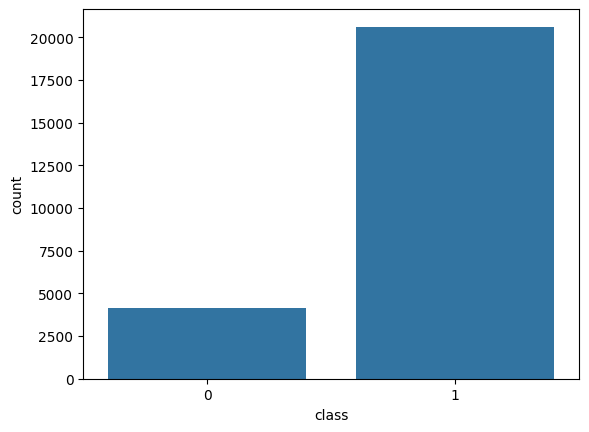

In [35]:
sns.countplot(x='class', data=raw_data)

In [36]:
imbalance_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [37]:
raw_data.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [38]:
# Let's change the name of the 'class' to 'label'
raw_data.rename(columns={'class':'label'},inplace=True)

In [39]:
raw_data.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [40]:
imbalance_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [41]:
# merge
frame = [imbalance_data,raw_data]
df = pd.concat(frame)

In [42]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [43]:
df.shape

(56745, 2)

<Axes: xlabel='label', ylabel='count'>

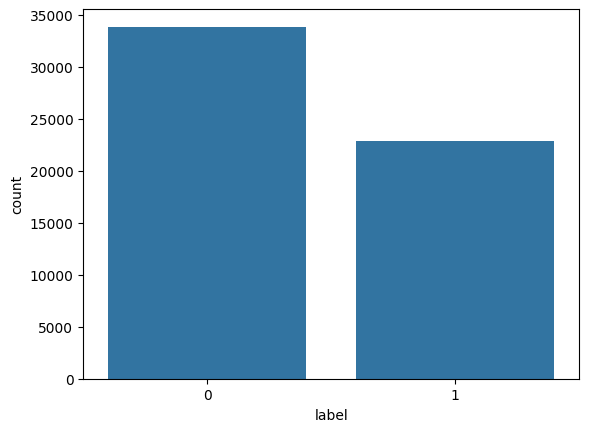

In [44]:
sns.countplot(x = 'label', data = df)

In [45]:
df['label'].value_counts()

,count
label,
0,33883
1,22862


# Pre-processing step

In [46]:
import re
import string
import nltk
from nltk.corpus import stopwords
#nltk.download('all')

In [47]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [48]:
stopword

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [49]:
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)

    # correct stopword removal
    words = [word for word in words.split(' ') if word not in stopword]
    words = " ".join(words)

    # correct stemming
    words = [stemmer.stem(word) for word in words.split(' ')]
    words = " ".join(words)

    return words


In [50]:
df['tweet'][1]

,tweet
1,@user @user thanks for #lyft credit i can't us...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...


In [51]:
df['tweet'] = df['tweet'].apply(data_cleaning)

In [52]:
df['tweet'][1]

,tweet
1,user user thank lyft credit cant use caus dont...
1,rt boy dat coldtyga dwn bad cuffin dat hoe ...


In [53]:
x = df['tweet']
y = df['label']

In [54]:
from sklearn.model_selection import train_test_split

# Let's split the data into train and test

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)


In [55]:
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42558 42558
14187 14187


In [56]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [57]:
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42558 42558
14187 14187


In [58]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)


## Feature Engineering

In [59]:
#!pip install keras
#!pip install tensorflow

In [60]:
import keras
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [61]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [62]:
sequences_matrix

array([[    0,     0,     0, ..., 15028,  6270,  3012],
       [    0,     0,     0, ...,   407,    95,   235],
       [    0,     0,     0, ...,   680,   634, 15029],
       ...,
       [    0,     0,     0, ...,   111,    77, 46968],
       [    0,     0,     0, ...,   910, 11895,   712],
       [    0,     0,     0, ...,   350,   314,     2]], dtype=int32)

In [63]:
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop

In [64]:
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [65]:
model.build(input_shape=(None, max_len))

In [66]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 300, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,080,501 (19.38 MB)

 Trainable params: 5,080,501 (19.38 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [69]:
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 5,validation_split=0.2)

Epoch 1/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.9431 - loss: 0.1610 - val_accuracy: 0.9431 - val_loss: 0.1597
Epoch 2/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9543 - loss: 0.1339 - val_accuracy: 0.9440 - val_loss: 0.1558
Epoch 3/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.9623 - loss: 0.1161 - val_accuracy: 0.9417 - val_loss: 0.1602
Epoch 4/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.9668 - loss: 0.1041 - val_accuracy: 0.9441 - val_loss: 0.1655
Epoch 5/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.9708 - loss: 0.0975 - val_accuracy: 0.9400 - val_loss: 0.1667


In [70]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [71]:
test_sequences_matrix

array([[    0,     0,     0, ...,  1401,     2,  2903],
       [    0,     0,     0, ...,   776,  2521, 14986],
       [    0,     0,     0, ...,   181,   214,   976],
       ...,
       [    0,     0,     0, ...,   217,    19,   221],
       [    0,     0,     0, ...,   352,     1,     1],
       [    0,     0,     0, ...,   265,   785,   244]], dtype=int32)

In [72]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

444/444 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - accuracy: 0.9410 - loss: 0.1776


In [73]:
lstm_prediction = model.predict(test_sequences_matrix)

444/444 ━━━━━━━━━━━━━━━━━━━━ 86s 191ms/step


In [74]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [76]:
print(confusion_matrix(y_test,res))

[[8133  320]
 [ 500 5234]]


In [77]:
print(accuracy_score(y_test,res))

0.9422006061887643


In [78]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [79]:
# Let's save the mdoel.
model.save("model.h5")

In [80]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [85]:
# Let's test our model on custom data.
test = 'i love this movie'

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    words = text.split(' ')
    words = [word for word in words if word not in stopword]
    words = [stemmer.stem(word) for word in words]
    text = " ".join(words)
    return text

test=[clean_text(test)]
print(test)

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)

pred = load_model.predict(padded)

print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")


['love movi']
[[6, 376]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
pred [[0.0087537]]
no hate
